# **1. Import & Setup**

This section establishes the analytical environment by installing required libraries, importing necessary modules, and configuring visualization settings. The analysis utilizes a combination of NLP tools (BERTopic, Gensim), data processing libraries (Pandas, NumPy), and visualization packages (Matplotlib, Plotly) to enable comprehensive topic modeling.

## **1.1 Library Installation**

In [ ]:
pip install gensim

In [ ]:
pip install bertopic

In [ ]:
pip install sentence-transformers

In [ ]:
pip install Sastrawi

## **1.2 Library Import**

In [ ]:
# Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Standard Library
import time
import re
import json
import warnings
from datetime import datetime
from collections import Counter
from copy import deepcopy

warnings.filterwarnings("ignore")

# Numerical & Data Handling
import numpy as np
import pandas as pd
from scipy import stats

# NLP & Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning / Topic Modeling
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

import joblib

# Gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Visualization (Static)
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager as fm, dates as mdates

import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go

Mounted at /content/drive


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **1.3 Configuration & Settings**

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

!wget -q -O Poppins-Regular.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Regular.ttf
!wget -q -O Poppins-Bold.ttf https://github.com/google/fonts/raw/main/ofl/poppins/Poppins-Bold.ttf

fm.fontManager.addfont("Poppins-Regular.ttf")
fm.fontManager.addfont("Poppins-Bold.ttf")

mpl.rcParams['font.family'] = "Poppins"

mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlecolor'] = '#808080'
mpl.rcParams['axes.labelcolor'] = '#808080'
mpl.rcParams['xtick.color'] = '#808080'
mpl.rcParams['ytick.color'] = '#808080'
mpl.rcParams['axes.edgecolor'] = '#808080'
mpl.rcParams['legend.labelcolor'] = '#808080'

mpl.rcParams['boxplot.boxprops.color'] = '#808080'
mpl.rcParams['boxplot.capprops.color'] = '#808080'
mpl.rcParams['boxplot.whiskerprops.color'] = '#808080'
mpl.rcParams['boxplot.medianprops.color'] = '#808080'
mpl.rcParams['boxplot.flierprops.color'] = '#808080'
mpl.rcParams['boxplot.meanprops.color'] = '#808080'

# **2. Data Loading  & Exploration**

This section loads the Telegram app review dataset and performs initial exploratory analysis. The dataset structure is examined, data quality is assessed, and key characteristics such as rating distribution and missing values are identified to inform the preprocessing strategy.

## **2.1 Load Dataset**

In [ ]:
df = pd.read_csv('ulasan_org.telegram.messenger.csv')
display(df.head())

,Nama User,Ulasan,Rating,Tanggal,Likes,Versi App
0,Pengguna Google,emng ga cocok aja di aku krna aku gratisan,1,2025-12-31 17:50:01,0,12.2.11
1,Pengguna Google,mantap,5,2025-12-31 17:21:01,0,NaN
2,Pengguna Google,gak bisa masuk jelek baget mending gak usah bikin apk kayak gini kalok bisa ku kasih bitang0 jelek bagetttttttt,1,2025-12-31 17:05:08,0,NaN
3,Pengguna Google,"kenapa intagram harus kepremium ,padahal baru install",1,2025-12-31 16:42:29,0,12.2.11
4,Pengguna Google,"gak bangetttt, masa mau login aja harus bayarr, ini emang davelopernya yang kikir atau gimana sih, gak banget serius",1,2025-12-31 16:25:59,0,NaN


## **2.2 Basic Info & Statistics**


In [ ]:
print("Dataset Shape:", df.shape)
print("\nDataset Information:")
df.info()

Dataset Shape: (100000, 6)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Nama User  100000 non-null  object
 1   Ulasan     100000 non-null  object
 2   Rating     100000 non-null  int64 
 3   Tanggal    100000 non-null  object
 4   Likes      100000 non-null  int64 
 5   Versi App  65994 non-null   object
dtypes: int64(2), object(4)
memory usage: 4.6+ MB


In [ ]:
print("Descriptive Statistics:")
display(df.describe())

Descriptive Statistics:


,Rating,Likes
count,100000.000000,100000.000000
mean,2.520360,3.766100
std,1.798916,102.462109
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,5.000000,0.000000
max,5.000000,9645.000000


In [ ]:
print("Rating Distribution:")
print(df['Rating'].value_counts())

Rating Distribution:
Rating
1    53296
5    30626
2     6774
3     5154
4     4150
Name: count, dtype: int64


## **2.3 Data Quality Check**

In [ ]:
print("Missing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Missing Values:
Nama User        0
Ulasan           0
Rating           0
Tanggal          0
Likes            0
Versi App    34006
dtype: int64

Duplicate Rows: 0


# **3. Data Preprocessing**

This section focuses on preparing raw review data for topic modeling. Reviews are segmented by sentiment (positive, negative, neutral) based on ratings, text cleaning techniques are applied to remove noise, and processed datasets are created for optimal BERTopic analysis.

## **3.0. Data Segmentation by Sentiment**

Sentiment labels are created based on rating scores: 4-5 stars as positive, 1-2 stars as negative, and 3 stars as neutral.

In [ ]:
# Create sentiment labels based on rating
df['sentiment'] = df['Rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

print("Sentiment Distribution:")
print(df['sentiment'].value_counts())
print("\nPercentage Distribution:")
print(df['sentiment'].value_counts(normalize=True) * 100)

Sentiment Distribution:
sentiment
negative    60070
positive    34776
neutral      5154
Name: count, dtype: int64

Percentage Distribution:
sentiment
negative    60.070
positive    34.776
neutral      5.154
Name: proportion, dtype: float64


Positive reviews (4-5 stars): 34776 (34.8%)
Negative reviews (1-2 stars): 60070 (60.1%)
Neutral reviews (3 stars): 5154 (5.2%)


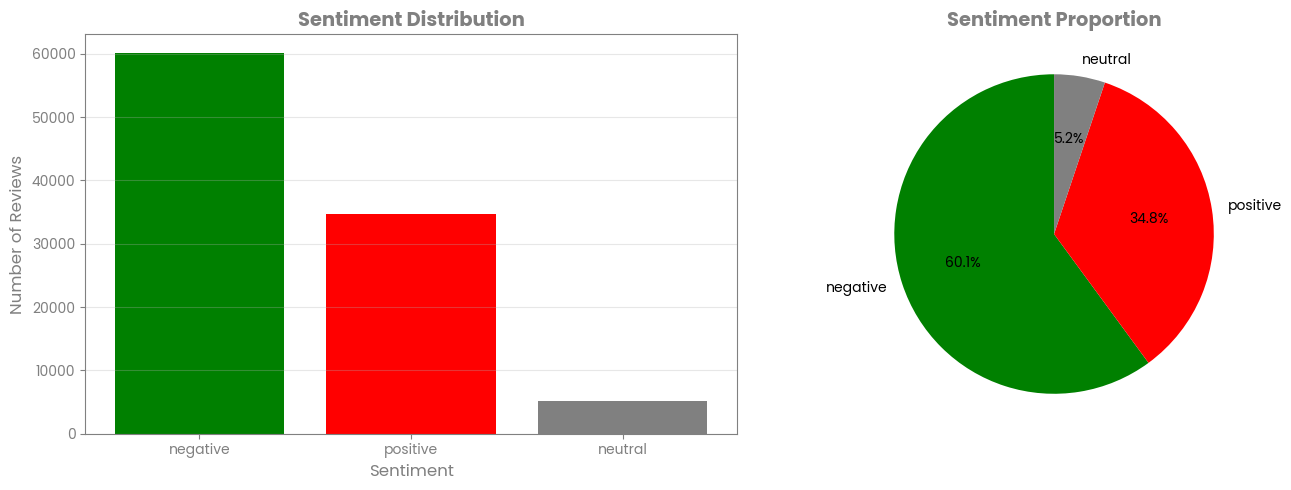

In [ ]:
# Split into sentiment groups
df_positive = df[df['Rating'] >= 4].copy()
df_negative = df[df['Rating'] <= 2].copy()
df_neutral = df[df['Rating'] == 3].copy()

print(f"Positive reviews (4-5 stars): {len(df_positive)} ({len(df_positive)/len(df)*100:.1f}%)")
print(f"Negative reviews (1-2 stars): {len(df_negative)} ({len(df_negative)/len(df)*100:.1f}%)")
print(f"Neutral reviews (3 stars): {len(df_neutral)} ({len(df_neutral)/len(df)*100:.1f}%)")

# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
sentiment_counts = df['sentiment'].value_counts()
ax1.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'gray'])
ax1.set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Pie chart
ax2.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
        colors=['green', 'red', 'gray'], startangle=90)
ax2.set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## **3.1. Text Cleaning**

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ''

    text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep basic punctuation (.,!?)
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Convert to lowercase
    text = text.lower()

    return text

# Apply cleaning to review column
df['Ulasan'] = df['Ulasan'].fillna('')
df['clean_review'] = df['Ulasan'].apply(clean_text)

# Remove empty reviews
df = df[df['clean_review'].str.len() > 0].copy()

print(f"Records after preprocessing: {len(df)}")
print(f"\nSample cleaned text:")
print(f"Original: {df['Ulasan'].iloc[0]}")
print(f"Cleaned:  {df['clean_review'].iloc[0]}")

# Update sentiment groups after cleaning
df_positive = df[df['Rating'] >= 4].copy()
df_negative = df[df['Rating'] <= 2].copy()
df_neutral = df[df['Rating'] == 3].copy()

Records after preprocessing: 99185

Sample cleaned text:
Original: emng ga cocok aja di aku krna aku gratisan
Cleaned:  emng ga cocok aja di aku krna aku gratisan


## **3.2. Final Processed Text**

In [ ]:
# Save preprocessed datasets
print("Saving preprocessed datasets...")
df_positive.to_csv('telegram_reviews_positive.csv', index=False)
df_negative.to_csv('telegram_reviews_negative.csv', index=False)
df_neutral.to_csv('telegram_reviews_neutral.csv', index=False)

print("✓ Saved: telegram_reviews_positive.csv")
print("✓ Saved: telegram_reviews_negative.csv")
print("✓ Saved: telegram_reviews_neutral.csv")

# **4. BERTopic Modeling on Negative Reviews**

This section applies BERTopic to negative reviews (1-2 stars) to identify recurring complaint themes. The process includes embedding generation, coherence optimization to determine optimal topic count, outlier handling, and topic interpretation with custom labels for actionable insights.

## **4.1. Data Preparation**

In [ ]:
# Extract negative reviews
docs_negative = df_negative['clean_review'].tolist()

print(f"Dataset Statistics:")
print(f"   • Total negative reviews: {len(docs_negative):,}")
print(f"   • Average review length: {np.mean([len(doc.split()) for doc in docs_negative]):.1f} words")
print(f"\nSample review:\n   {docs_negative[0][:200]}...")

Dataset Statistics:
   • Total negative reviews: 59,956
   • Average review length: 14.2 words

Sample review:
   emng tidak cocok saja di aku karena aku gratisan...


## **4.2. Model Configuration**

In [ ]:
# Embedding Model
print("Initializing embedding model...")
print("   Model: paraphrase-multilingual-MiniLM-L12-v2")
print("   Reason: Optimized for Indonesian language support")
neg_embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("   ✓ Embedding model loaded successfully")

Initializing embedding model...
   Model: paraphrase-multilingual-MiniLM-L12-v2
   Reason: Optimized for Indonesian language support
   ✓ Embedding model loaded successfully


In [ ]:
# Custom Stopwords for Indonesian
print("Configuring stopwords...")
custom_stopwords = ["yang", "yg", "untuk", "dengan", "pada", "dari", "ini", "itu", "di", "ke", "adalah", "atau", "dan", "juga", "bisa", "gua", "saya", "tidak", "nya", "banget", "sangat", "sekali", "jelek", "bagus", "buruk", "banyak", "udh", "pake", "tetep", "kena", "dikit", "bad", "kasih", "bgt", "aplikasi", "apk", "telegram", "tele", "aja", "ada", "padahal", "kenapa", "tapi", "malah", "apa", "ya", "sama", "buat", "kalo", "kalau", "emosi", "stress", "stres", "susah", "saja", "aku", "jelas", "suruh", "bikin", "sering", "my", "to", "the", "is", "and", "it", "but", "yaa", "asik", "gbisa",  "sekarang", "baru", "lagi", "dulu", "sudah", "udah", "tiba", "makin", "lain", "terus", "pas", "saat", "gk", "gak", "ga", "gabisa", "tolong", "harus", "mohon", "mau", "ok", "oke", "good", "mantap", "nice", "sip", "kak", "log", "in", "sign", "code", "why", "no", "nomer", "jadi", "bintang", "orang", "melakukan", "terjadi", "menerima", "bkin", "bikin", "buat", "kek", "kayak", "macam", "mulu", "trus", "terus", "sekitar", "mana", "kurang", "paling", "suka", "karena", "sebab", "satu", "dua", "tiga", "kali", "masa", "kebelet", "naik", "mana", "siapa", "kapan", "kok", "begitu", "begini", "serta", "daripada", "hrus", "blm", "udah", "sdh", "tdk", "gk", "ga", "krn", "bkn", "dlm",  "ny", "sy", "gw", "lu", "luweh", "emang", "emng", "mank", "klo", "klw", "an", "the", "is", "for", "in", "on", "at", "try", "again", "please",  "now", "back", "go", "up", "down", "error", "error error", "pilih", "klik", "tekan", "liat", "lihat", "muncul", "masuk", "keluar", "kasih", "beri", "tambah", "kurang", "banget", "bgt", "parah", "gitu", "sih", "aneh", "kok", "lah", "dong", "kecewa", "parah", "me", "do", "anything", "got", "my", "been", "this", "is", "fitur", "otomatis", "feature", "pakai", "pake", "klo", "klw", "sdh", "blm", "semua", "ko", "doang", "dlu", "selalu", "pernah", "lewat", "jangan", "dapet", "coba", "udah", "sudah", "bisa", "gak", "ga", "nggak", "padahal", "pada", "buat", "bikin", "lagi", "tetap", "malah", "kalo", "kalau", "karena", "tapi", "untuk", "yang", "dan", "di", "as", "you", "soon", "team", "number", "occurred", "later", "please", "my", "gajelas", "ribet", "tolol", "sampah", "pengguna", "buka", "perbaiki", "very", "not", "are", "because", "application", "work", "this", "is", "app", "please", "plis", "profile", "lg", "ngk", "nga", "jls", "apaan", "hrs", "knp", "utk", "setelah", "semakin", "anda", "ingin", "kata", "sendiri", "ulang", "pake", "biar", "kudu", "cuma", "disuruh", "balik", "sih", "dong", "tuh", "nih", "dapat", "mendapatkan", "belum", "masuknya", "dibuka", "muncul", "st", "prem", "aplikasinya", "uang", "user", "indonesia", "ku", "dpt", "tak", "bagaimana", "bat", "tuh", "sih", "nya", "ngapain", "ngapa", "skrg", "skrng", "apl", "apk", "soalnya", "maaf", "kasi", "kasih", "tapi", "nanti", "send", "unable", "tulisan", "selesai", "tanpa", "cari", "pencarian", "hati", "bisa", "tolong", "mohon", "padahal", "gimana", "udh", "udah", "sdh", "sudah"]
print(f"   ✓ {len(custom_stopwords)} stopwords configured")

Configuring stopwords...
   ✓ 351 stopwords configured


In [ ]:
# Vectorizer Configuration
print("Setting up vectorizer...")
neg_vectorizer_model = CountVectorizer(max_df=0.90, min_df=2, ngram_range=(1, 2), stop_words=custom_stopwords)
print("   ✓ Vectorizer configured with n-gram range (1,2)")

Setting up vectorizer...
   ✓ Vectorizer configured with n-gram range (1,2)


## **4.3. Initial Model Training**

In [ ]:
neg_topic_model = BERTopic(embedding_model=neg_embedding_model, vectorizer_model=neg_vectorizer_model, min_topic_size=10, nr_topics='auto', verbose=True, language='indonesian')

print("Fitting model to documents...")
neg_topics, neg_probabilities = neg_topic_model.fit_transform(docs_negative)

print("\n✓ Initial model training complete!")
print(f"   • Topics discovered: {len(set(neg_topics)) - 1}")
print(f"   • Outlier documents: {sum(1 for t in neg_topics if t == -1)}")

## **4.4. Coherence Model Optimization**

In [ ]:
# Prepare data for coherence calculation
print("Preparing corpus for coherence evaluation...")
neg_cleaned_docs = [doc.split() for doc in docs_negative]
neg_dictionary = Dictionary(neg_cleaned_docs)
corpus = [neg_dictionary.doc2bow(text) for text in neg_cleaned_docs]
print(f"   ✓ Dictionary size: {len(neg_dictionary)} unique tokens")

In [ ]:
# Coherence calculation function
def calculate_coherence(model, topics_list, text_data, dictionary):
    topic_words = []
    for topic in topics_list:
        words = [word for word, _ in model.get_topic(topic)[:10]]
        valid_words = [w for w in words if w in dictionary.token2id]
        if valid_words:
            topic_words.append(valid_words)

    if not topic_words:
        return 0.0

    try:
        cm = CoherenceModel(topics=topic_words, texts=text_data, dictionary=neg_dictionary, coherence='c_v')
        return cm.get_coherence()
    except Exception as e:
        print(f"   Warning: Coherence calculation failed - {str(e)}")
        return 0.0

# Grid search for optimal topic count
print("Running grid search for optimal topic count...")
print("   Range: 5 to 20 topics")
start, limit, step = 5, 20, 1
num_topics_list = range(start, limit + 1, step)
coherence_scores = []

for num_topics in num_topics_list:
    model_tmp = deepcopy(neg_topic_model)
    model_tmp.reduce_topics(docs_negative, nr_topics=num_topics)

    active_topics = [t for t in model_tmp.get_topic_info()['Topic'] if t != -1]

    score = calculate_coherence(model_tmp, active_topics, neg_cleaned_docs, neg_dictionary)
    coherence_scores.append(score)
    print(f"   Topics: {num_topics:2d} | Coherence: {score:.4f}")

# Find optimal number
optimal_idx = np.argmax(coherence_scores)
optimal_topics = list(num_topics_list)[optimal_idx]
optimal_score = coherence_scores[optimal_idx]

print(f"\nOptimal configuration found:")
print(f"   • Number of topics: {optimal_topics}")
print(f"   • Coherence score: {optimal_score:.4f}")

In [ ]:
# Visualize coherence scores
df_coherence = pd.DataFrame({
    'Num_Topics': list(num_topics_list),
    'Coherence_Score': coherence_scores
})

fig = go.Figure(data=go.Scatter(x=df_coherence['Num_Topics'], y=df_coherence['Coherence_Score'], mode='lines+markers',marker=dict(size=8),line=dict(width=2)))
fig.add_trace(go.Scatter(x=[optimal_topics], y=[optimal_score], mode='markers', marker=dict(size=15, color='red', symbol='star'), name='Optimal'))
fig.update_layout(title='Coherence Score vs Number of Topics', xaxis_title='Number of Topics', yaxis_title='Coherence Score (C_V)', hovermode='x unified', template='plotly_white')
fig.show()

## **4.5. Topic Reduction & Outlier Handling**

In [ ]:
final_num_topics = 6
print(f"Reducing to {final_num_topics} topics...")
neg_topic_model.reduce_topics(docs_negative, nr_topics=final_num_topics)
neg_topics = neg_topic_model.topics_

print("Handling outliers...")
new_topics = neg_topic_model.reduce_outliers(docs_negative, neg_topics, strategy="c-tf-idf")
neg_topic_model.update_topics(docs_negative, topics=new_topics, vectorizer_model=neg_vectorizer_model)

topic_info = neg_topic_model.get_topic_info()

In [ ]:
# Save model
model_path = f"bertopic_model_topics_negative_reviews"
neg_topic_model.save(model_path)
print(f"   ✓ Model saved to: {model_path}")

## **4.6. Topic Information & Keywords Analysis**

In [ ]:
print(f"Topic Summary (FINAL - {final_num_topics} topics):")
print(f"   • Total topics: {len(topic_info[topic_info['Topic'] != -1])}")
print(f"   • Outlier documents: {topic_info[topic_info['Topic'] == -1]['Count'].values[0] if -1 in topic_info['Topic'].values else 0}")

print("\n" + "-" * 80)
print(f"Top Keywords per Topic ({final_num_topics} Topics):")
print("-" * 80)

for topic_id in topic_info['Topic'].values:
    if topic_id != -1:
        words = neg_topic_model.get_topic(topic_id)
        if words and isinstance(words, list):
            print(f"\nTopic {topic_id}:")
            for word, score in words[:10]:
                print(f"   • {word:20s} ({score:.4f})")

2026-01-13 07:46:12,034 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 07:46:12,035 - BERTopic - Topic reduction - Number of topics (6) is equal or higher than the clustered topics(6).
2026-01-13 07:46:12,036 - BERTopic - Representation - Fine-tuning topics using representation models.


Reducing to 6 topics...


2026-01-13 07:46:14,028 - BERTopic - Representation - Completed ✓


Handling outliers...


2026-01-13 07:46:14,889 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Topic Summary (FINAL - 6 topics):
   • Total topics: 5
   • Outlier documents: 1245

--------------------------------------------------------------------------------
Top Keywords per Topic (6 Topics):
--------------------------------------------------------------------------------

Topic 0:
   • kode                 (0.0898)
   • sms                  (0.0537)
   • verifikasi           (0.0518)
   • kode verifikasi      (0.0407)
   • otp                  (0.0360)
   • kirim                (0.0337)
   • email                (0.0299)
   • kode otp             (0.0275)
   • lama                 (0.0266)
   • dikirim              (0.0238)

Topic 1:
   • banned               (0.0454)
   • blokir               (0.0436)
   • eror                 (0.0287)
   • internal             (0.0284)
   • kesalahan            (0.0254)
   • grup                 (0.0216)
   • ban                  (0.0201)
   • diblokir             (0.0187)
   • terlalu              (0.0181)
   • gue                  (0.016

In [ ]:
# Save model
model_path = f"bertopic_model_topics_negative_reviews"
neg_topic_model.save(model_path)
print(f"   ✓ Model saved to: {model_path}")

2026-01-13 08:04:29,085 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


   ✓ Model saved to: bertopic_model_topics_negative_reviews


## **4.7. Topic Labeling & Visualization**

In [ ]:
# Define Topic Labels
custom_labels = {
    -1: "Outliers",
    0: "Authentication & OTP Failure",
    1: "Account Bans & System Errors",
    2: "Monetization & Premium Complaints",
    3: "Media Upload & Story Bugs",
    4: "Translation Issues & Spam Content"
}

neg_topic_model.set_topic_labels(custom_labels)
neg_info_df = neg_topic_model.get_topic_info()

print("Topic Info Summary:")
display(neg_info_df[['Topic', 'Count', 'Name', 'CustomName']].head(10))

Topic Info Summary:


,Topic,Count,Name,CustomName
0,-1,1245,-1_login login_daftar login_login daftar_premium premium,Outliers
1,0,40221,0_kode_sms_verifikasi_kode verifikasi,Authentication & OTP Failure
2,1,10473,1_banned_blokir_eror_internal,Account Bans & System Errors
3,2,6441,2_login bayar_story premium_kaya_gini,Monetization & Premium Complaints
4,3,1242,3_foto_cerita_profil_status,Media Upload & Story Bugs
5,4,334,4_bahasa_terjemahan_translate_berfungsi,Translation Issues & Spam Content


In [ ]:
# Bar Chart (Top Keywords per Topic)
fig_bar = neg_topic_model.visualize_barchart(top_n_topics=8, custom_labels=True, title="Top Keywords by Topic")
fig_bar.show()

# Intertopic Distance Map
fig_map = neg_topic_model.visualize_topics(custom_labels=True, title="Intertopic Distance Map")
fig_map.show()

# Similarity Heatmap
fig_heatmap = neg_topic_model.visualize_heatmap(custom_labels=True, title="Topic Similarity Matrix")
fig_heatmap.show()

In [ ]:
# Export to Excel
neg_report_df = neg_info_df[['Topic', 'Count', 'CustomName', 'Representation']]
neg_report_df.columns = ['Topic ID', 'Frequency', 'Topic Label', 'Top Keywords']

# Save to Excel
neg_report_df.to_excel("neg_topic_modeling_results_english.xlsx", index=False)
print("Export complete: 'neg_topic_modeling_results_english.xlsx'")

Export complete: 'neg_topic_modeling_results_english.xlsx'


## **4.8. Topic Quality Metrics**

In [ ]:
# TOPIC DIVERSITY SCORE
print("Topic Diversity Score")
neg_topics_dict = neg_topic_model.get_topics()
neg_unique_words = set()
neg_total_words = 0

for topic_id, topic_words in neg_topics_dict.items():
    if topic_id != -1 and topic_words:
        words = [w for w, _ in topic_words[:10]]
        neg_unique_words.update(words)
        neg_total_words += len(words)

neg_diversity = len(neg_unique_words) / neg_total_words if neg_total_words > 0 else 0
print(f"   • Diversity Score: {neg_diversity:.4f}")
print(f"   • Unique words: {len(neg_unique_words)} / {neg_total_words}")
print(f"   • Interpretation: {'High diversity - topics are distinct' if neg_diversity > 0.7 else 'Moderate diversity - some overlap between topics'}")

Topic Diversity Score
   • Diversity Score: 1.0000
   • Unique words: 50 / 50
   • Interpretation: High diversity - topics are distinct


In [ ]:
# REPRESENTATIVE DOCUMENTS PER TOPIC
print("Representative Documents per Topic:")

for topic_id in range(final_num_topics):
    if topic_id in custom_labels:
        print(f"\nTopic {topic_id}: {custom_labels[topic_id]}")

        # Get document indices for this topic
        topic_indices = [i for i, t in enumerate(neg_topics) if t == topic_id]

        if topic_indices:
            # Get first 3 documents as examples
            sample_docs = [docs_negative[i] for i in topic_indices[:3]]

            for idx, doc in enumerate(sample_docs, 1):
                # Truncate if too long
                doc_preview = doc[:150] + "..." if len(doc) > 150 else doc
                print(f"   {idx}. {doc_preview}")

Representative Documents per Topic:

Topic 0: Authentication & OTP Failure
   1. kenapa intagram harus kepremium padahal baru install
   2. aku masih suka sama telegram dulu kalau sekarang mah telegram lebih mentingin uang bukan nya bikin keringanan rakyat buat pake aplikasi telegramnya
   3. kenapa mau masuk harus bayar tidak kaya telegram yang dulu

Topic 1: Account Bans & System Errors
   1. emng tidak cocok saja di aku karena aku gratisan
   2. apk mkin sni mkin kgak jlas gtw mo brkata apa
   3. busuk

Topic 2: Monetization & Premium Complaints
   1. baru jg unduh sudah harus bayar hasil nyajg belum jelas
   2. kok jadi berbayar bikin akun juga
   3. apaan ini kok sekarang mesti bayar

Topic 3: Media Upload & Story Bugs
   1. my emoji gone nowhere
   2. emoji reaction sama pas dikirim ko ngeblur sih padahal sudah update ke versi baru tapi malah ngeblur gitu aneh banget jadi buruk ini telegram sekarang
   3. apaansih tiba tiba erorr gbsa liat react emoji biasa sama gbsa liat bbrp em

In [ ]:
# TOPIC SEVERITY ANALYSIS
print("Topic Severity Analysis:")

# Add topic assignments to dataframe
df_negative['topic'] = neg_topics

# Calculate severity metrics
neg_severity = df_negative.groupby('topic').agg({'Rating': ['mean', 'count']}).round(2)
neg_severity.columns = ['Avg_Rating', 'Review_Count']

# Calculate severity score: (5 - avg_rating) * log(count)
neg_severity['Severity_Score'] = ((5 - neg_severity['Avg_Rating']) * np.log1p(neg_severity['Review_Count'])).round(2)
neg_severity['Topic_Label'] = neg_severity.index.map(lambda x: custom_labels.get(x, f"Topic {x}"))
neg_severity = neg_severity.sort_values('Severity_Score', ascending=False)

print("\nSeverity Ranking:")
display(neg_severity)

Topic Severity Analysis:

Severity Ranking:


,Avg_Rating,Review_Count,Severity_Score,Topic_Label
topic,,,,
0,1.11,25640,39.49,Authentication & OTP Failure
-1,1.11,24904,39.38,Outliers
1,1.14,5238,33.06,Account Bans & System Errors
2,1.09,3736,32.16,Monetization & Premium Complaints
3,1.22,362,22.28,Media Upload & Story Bugs
4,1.20,76,16.51,Translation Issues & Spam Content


In [ ]:
# PRIORITY MATRIX
print("Priority Matrix (for actionable insights):")

neg_severity['Priority'] = 'Low'
frequency_threshold = 50

# Critical: High severity + high frequency
mask_critical = (neg_severity['Severity_Score'] > neg_severity['Severity_Score'].quantile(0.75)) & (neg_severity['Review_Count'] > frequency_threshold)
neg_severity.loc[mask_critical, 'Priority'] = 'Critical'

# High: High severity OR high frequency
mask_high = ((neg_severity['Severity_Score'] > neg_severity['Severity_Score'].quantile(0.5)) & (neg_severity['Review_Count'] > frequency_threshold/2)) & (neg_severity['Priority'] != 'Critical')
neg_severity.loc[mask_high, 'Priority'] = 'High'

# Medium: Moderate severity or frequency
mask_medium = (neg_severity['Severity_Score'] > neg_severity['Severity_Score'].quantile(0.25)) & (neg_severity['Priority'] == 'Low')
neg_severity.loc[mask_medium, 'Priority'] = 'Medium'

print("\nPriority Distribution:")
print(neg_severity['Priority'].value_counts())

display(neg_severity[['Topic_Label', 'Avg_Rating', 'Review_Count', 'Severity_Score', 'Priority']])

# Visualize Priority Matrix
fig = go.Figure()

for priority in ['Critical', 'High', 'Medium', 'Low']:
    df_priority = neg_severity[neg_severity['Priority'] == priority]
    color_map = {'Critical': 'red', 'High': 'orange', 'Medium': 'yellow', 'Low': 'green'}
    fig.add_trace(go.Scatter(x=df_priority['Review_Count'], y=df_priority['Severity_Score'], mode='markers+text', name=priority, marker=dict(size=15, color=color_map[priority]), text=df_priority.index, textposition="top center", hovertemplate='<b>%{text}</b><br>Count: %{x}<br>Severity: %{y:.2f}<extra></extra>'))

fig.update_layout(title='Priority Matrix: Severity vs Frequency', xaxis_title='Review Count (Frequency)', yaxis_title='Severity Score', hovermode='closest', template='plotly_white', showlegend=True)
fig.show()

Priority Matrix (for actionable insights):

Priority Distribution:
Priority
Critical    2
Low         2
High        1
Medium      1
Name: count, dtype: int64


,Topic_Label,Avg_Rating,Review_Count,Severity_Score,Priority
topic,,,,,
0,Authentication & OTP Failure,1.11,25640,39.49,Critical
-1,Outliers,1.11,24904,39.38,Critical
1,Account Bans & System Errors,1.14,5238,33.06,High
2,Monetization & Premium Complaints,1.09,3736,32.16,Medium
3,Media Upload & Story Bugs,1.22,362,22.28,Low
4,Translation Issues & Spam Content,1.20,76,16.51,Low


In [ ]:
# EXPORT COMPREHENSIVE REPORT
print("Exporting comprehensive report...")

# Combine all metrics
neg_comprehensive_report = neg_severity.copy()
neg_comprehensive_report.insert(0, 'Topic_ID', neg_comprehensive_report.index)
neg_comprehensive_report['Top_Keywords'] = neg_comprehensive_report['Topic_ID'].apply(lambda x: ', '.join([word for word, _ in neg_topic_model.get_topic(x)[:5]]) if x != -1 else 'N/A')

# Save to Excel
neg_comprehensive_report.to_excel("negative_topics_comprehensive_report.xlsx", index=False)
print("   ✓ Saved: negative_topics_comprehensive_report.xlsx")

Exporting comprehensive report...
   ✓ Saved: negative_topics_comprehensive_report.xlsx

Negative reviews analysis complete!


# **5. BERTopic Modeling on Positive Reviews**

This section applies BERTopic to positive reviews (4-5 stars) to identify what users appreciate most about Telegram. Topics are optimized for coherence, and themes are extracted to highlight the app's strengths and competitive advantages.

## **5.1. Data Preparation**

In [ ]:
# Extract positive reviews
docs_positive = df_positive['clean_review'].tolist()

print(f"Dataset Statistics:")
print(f"   • Total positive reviews: {len(docs_positive):,}")
print(f"   • Average review length: {np.mean([len(doc.split()) for doc in docs_positive]):.1f} words")
print(f"\nSample review:\n   {docs_positive[0][:200]}...")

Dataset Statistics:
   • Total positive reviews: 34,060
   • Average review length: 5.4 words

Sample review:
   mantap...


## **5.2. Model Configuration**

In [ ]:
# Embedding Model
print("Initializing embedding model...")
print("   Model: paraphrase-multilingual-MiniLM-L12-v2")
print("   Reason: Optimized for Indonesian language support")
pos_embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("   ✓ Embedding model loaded successfully")

Initializing embedding model...
   Model: paraphrase-multilingual-MiniLM-L12-v2
   Reason: Optimized for Indonesian language support
   ✓ Embedding model loaded successfully


In [ ]:
# Custom Stopwords for Indonesian
print("Configuring stopwords...")
custom_stopwords = ["yang", "yg", "untuk", "pada", "ke", "para", "namun", "menurut", "antara", "dia", "dua", "ia", "seperti", "jika", "sehingga", "kembali", "dan", "ini", "itu", "dalam", "dari", "tidak", "gak", "ga", "dengan", "di", "oleh", "karena", "ada", "adalah", "akan", "atau", "sudah", "telah", "dapat", "juga", "lebih", "bisa","saya", "aku", "nya", "ya", "aja", "sih", "lagi", "kok", "tapi", "assalamualaikum", "aplikasi", "apk", "telegram", "tele", "aplikasinya", "bagus", "sangat", "ok", "oke", "mantap", "banget", "sekali", "baik", "keren", "very", "good", "bgus", "verry", "ferry", "nice", "membantu", "mudah", "bermanfaat", "baguss", "memuaskan", "best", "top", "buat", "tolong", "kasih", "mau", "suka", "bisa", "harus", "susah", "mohon", "kenapa", "apa", "mengapa", "bagaimana", "kapan", "dimana", "banyak", "baru", "lagi", "sudah", "the", "app", "dong", "sih", "deh", "kok", "kita", "semua", "warga", "okok", "gas", "jos", "mantap", "mantapp", "buruan", "kadangg", "gan", "min", "tolong", "mohon", "smoga", "sja", "pending", "membatu", "ahmad", "dulu", "sekarang", "kalau", "bikin", "bintang", "terbaik", "berguna", "lumayan", "puas", "semoga", "coba", "biasa", "luar", "code", "saja", "gua", "cukup", "jadi", "lah", "ye", "mantab", "seru", "menarik", "terimakasih", "job", "bokep", "fery", "gass", "sayang","no", "belum", "padahal", "pas", "sama", "kan", "semakin", "makin", "terus", "orang", "kami", "kalian", "kita", "bagi", "setelah", "to", "sama", "buat", "gk", "bangett", "eror", "bang", "jir", "njir", "ter", "gan", "kak", "min", "bro", "tambahin", "buruk", "jelek", "parah", "enak", "bagus", "keren", "mantap",  "istimewa", "cocok", "semangat", "alhamdulillah", "lumayan",  "sukses", "kecewa", "sayang", "melihat", "ingin", "mau", "perbaiki", "aktifkan", "ulang",  "tambahkan", "bikin", "instal", "coba", "muncul", "keluar", "masuk", "yaa", "please", "yg", "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "bisa", "kalo", "kalau", "biar", "sih", "dong", "kok", "deh", "mah", "tuh", "kah", "aja", "saja", "udah", "sudah", "gan", "sis", "min", "kak", "bang", "bro", "guys", "ga", "gak", "gk", "enggak", "lg", "pake", "tiba", "terima", "kasih", "tadi", "gini", "gitu", "maju", "berkembang", "tingkatkan", "tiada", "kemajuan", "kedepannya", "tingkat", "usaha", "masa", "jaya", "sukses", "mantap", "bagus", "top", "keren", "good", "best", "gw", "malah", "amat", "depan", "luas", "modal", "efisien", "ny", "tak", "sya", "makasih", "thanks", "teknologi", "inovatif", "keunggulan", "barat", "ruangan", "sangar", "perubahan", "kedepan", "sekitar", "kek", "ni", "sihh", "tuh", "dah", "deh", "donk", "minusnya", "disini", "sesuai", "agar", "tanggapi", "kec", "rw", "rt",  "future", "ss", "nge", "lancar", "berkomunikasi", "warahmatullahi", "efisiensi", "kulon", "jawa", "cakep", "ip", "minn", "kaya", "tahun", "bagus", "good", "sangat", "mantap", "baik", "keren", "very", "sekali",  "banget", "oke", "baguss", "nice", "best", "verry", "bgus", "mantab", "membantu", "mudah", "bermanfaat", "memuaskan", "berguna", "top", "bisa", "saya", "aku", "buat", "tolong", "kasih", "mau", "suka",  "harus", "coba", "mohon", "perbaiki", "terima", "terimakasih", "tidak", "yang", "dan", "ini", "untuk", "sudah", "ada", "tapi",  "dengan", "dari", "juga", "lebih", "jadi", "karena", "itu", "dalam", "saja", "kalau", "sama", "kalo", "kenapa", "apa", "bagaimana", "lagi", "baru", "sekarang", "dulu",  "padahal", "lama", "terus", "dong", "nya", "orang", "kita", "teman", "semua", "lain", "kok", "sih", "telegram", "apk", "tele", "aplikasi", "aplikasinya", "app", "the", "banyak", "semoga", "dapat", "pesan", "bintang", "kode", "akun", "masuk", "login", "sms", "verifikasi", "nomor",  "daftar", "update", "download", "premium", "story", "film", "nonton", "komunikasi", "fitur", "susah", "bgus", "verry", "hp", "email", "buka", "kirim", "otp", "bug", "sering",  "cara", "ku", "kali", "error", "eror", "masalah", "gagal", "cuma", "hanya", "tapi", "tpi", "tetapi", "masih", "selalu", "kadang", "sering", "pernah", "akan", "sedang", "sudah", "belum", "bisa", "dapat", "mau", "ingin", "pokonya", "pokoknya", "mungkin", "padahal", "kalau", "kalo", "lewat", "melalui", "tengah", "antara", "sangat", "banget", "bnget", "jelas", "tentu", "pasti", "langsung", "terus", "kemudian", "yg", "ga", "gak", "nggak", "gk", "sy", "aku", "gw", "gua", "gue", "lu", "kln", "kalian", "ad", "ada", "klo", "ko", "kok", "kyk", "kek", "kayak", "macem", "bgt", "aj", "aja", "dgn", "dng", "ang", "nya", "udh", "udah", "sdh", "ni", "nih", "tu", "tuh", "jd", "jdi", "jadi", "menggunakan", "gunakan", "guna", "mengerti", "menerima", "terima", "mendapatkan", "dapet", "nyampe", "membantu", "bantu", "bikin", "buat", "kasih", "bilang", "ngomong", "minta", "cari", "masuk", "keluar", "buka", "tutup", "diperbaiki", "perbaiki", "tambah", "tambahi", "in", "on", "at", "to", "for", "of", "the", "and", "is", "are", "my", "your", "you", "we", "they", "he", "she", "it", "me", "us", "users", "brother", "bro", "like", "good", "nice", "please", "help", "thanks", "thank", "aplikasi", "apk", "app", "apps", "situs", "web",  "pihak", "orang", "teman", "temen", "pakai", "memakai", "terpakai", "mencari", "cari", "dicari", "ganti", "mengganti", "diganti", "mengunakan", "digunakan",  "kurang", "lebih", "paling", "agak", "lumayan", "sedikit", "banyak", "sendiri", "saudara", "semua", "maaf", "sori", "sorry", "jangan", "dilarang", "tolong", "mohon", "harap", "gabisa", "gbisa", "gabole", "apknya", "telgram", "tele", "nomer", "nomor"]
print(f"   ✓ {len(custom_stopwords)} stopwords configured")

Configuring stopwords...
   ✓ 617 stopwords configured


In [ ]:
# Vectorizer Configuration
print("Setting up vectorizer...")
pos_vectorizer_model = CountVectorizer(max_df=0.90, min_df=2, ngram_range=(1, 2), stop_words=custom_stopwords)
print("   ✓ Vectorizer configured with n-gram range (1,2)")

Setting up vectorizer...
   ✓ Vectorizer configured with n-gram range (1,2)


## **5.3. Initial Model Training**

In [ ]:
pos_topic_model = BERTopic(embedding_model=pos_embedding_model, vectorizer_model=pos_vectorizer_model, min_topic_size=10, nr_topics='auto', verbose=True, language='indonesian')

print("Fitting model to documents...")
pos_topics, pos_probabilities = pos_topic_model.fit_transform(docs_positive)

print("\n✓ Initial model training complete!")
print(f"   • Topics discovered: {len(set(pos_topics)) - 1}")
print(f"   • Outlier documents: {sum(1 for t in pos_topics if t == -1)}")

2026-01-13 10:31:31,597 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting model to documents...


Batches:   0%|          | 0/1065 [00:00<?, ?it/s]

2026-01-13 10:39:17,319 - BERTopic - Embedding - Completed ✓
2026-01-13 10:39:17,322 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 10:41:32,386 - BERTopic - Dimensionality - Completed ✓
2026-01-13 10:41:32,388 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 10:41:40,969 - BERTopic - Cluster - Completed ✓
2026-01-13 10:41:40,970 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-01-13 10:41:41,417 - BERTopic - Representation - Completed ✓
2026-01-13 10:41:41,419 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:41:42,313 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:41:43,071 - BERTopic - Representation - Completed ✓
2026-01-13 10:41:43,084 - BERTopic - Topic reduction - Reduced number of topics from 737 to 412



✓ Initial model training complete!
   • Topics discovered: 411
   • Outlier documents: 7232


## **5.4. Coherence Model Optimization**

In [ ]:
# Prepare data for coherence calculation
print("Preparing corpus for coherence evaluation...")
pos_cleaned_docs = [doc.split() for doc in docs_positive]
pos_dictionary = Dictionary(pos_cleaned_docs)
corpus = [pos_dictionary.doc2bow(text) for text in pos_cleaned_docs]
print(f"   ✓ Dictionary size: {len(pos_dictionary)} unique tokens")

Preparing corpus for coherence evaluation...
   ✓ Dictionary size: 14063 unique tokens


In [ ]:
# Coherence calculation function
def calculate_coherence(model, topics_list, text_data, dictionary):
    topic_words = []
    for topic in topics_list:
        words = [word for word, _ in model.get_topic(topic)[:10]]
        valid_words = [w for w in words if w in dictionary.token2id]
        if valid_words:
            topic_words.append(valid_words)

    if not topic_words:
        return 0.0

    try:
        cm = CoherenceModel(topics=topic_words, texts=text_data, dictionary=dictionary, coherence='c_v')
        return cm.get_coherence()
    except Exception as e:
        print(f"   Warning: Coherence calculation failed - {str(e)}")
        return 0.0

# Grid search for optimal topic count
print("Running grid search for optimal topic count...")
print("   Range: 5 to 20 topics")
start, limit, step = 5, 20, 1
num_topics_list = range(start, limit + 1, step)
coherence_scores = []

for num_topics in num_topics_list:
    model_tmp = deepcopy(pos_topic_model)
    model_tmp.reduce_topics(docs_positive, nr_topics=num_topics)

    active_topics = [t for t in model_tmp.get_topic_info()['Topic'] if t != -1]

    score = calculate_coherence(model_tmp, active_topics, pos_cleaned_docs, pos_dictionary)
    coherence_scores.append(score)
    print(f"   Topics: {num_topics:2d} | Coherence: {score:.4f}")

# Find optimal number
optimal_idx = np.argmax(coherence_scores)
optimal_topics = list(num_topics_list)[optimal_idx]
optimal_score = coherence_scores[optimal_idx]

print(f"\nOptimal configuration found:")
print(f"   • Number of topics: {optimal_topics}")
print(f"   • Coherence score: {optimal_score:.4f}")

Running grid search for optimal topic count...
   Range: 5 to 20 topics


2026-01-13 10:42:16,204 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:16,288 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:16,529 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:16,536 - BERTopic - Topic reduction - Reduced number of topics from 412 to 5


   Topics:  5 | Coherence: 0.2516


2026-01-13 10:42:21,860 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:21,939 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:22,197 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:22,204 - BERTopic - Topic reduction - Reduced number of topics from 412 to 6


   Topics:  6 | Coherence: 0.2766


2026-01-13 10:42:29,610 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:29,758 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:30,072 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:30,080 - BERTopic - Topic reduction - Reduced number of topics from 412 to 7


   Topics:  7 | Coherence: 0.3952


2026-01-13 10:42:34,062 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:34,141 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:34,425 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:34,431 - BERTopic - Topic reduction - Reduced number of topics from 412 to 8


   Topics:  8 | Coherence: 0.3907


2026-01-13 10:42:39,666 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:39,744 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:40,092 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:40,101 - BERTopic - Topic reduction - Reduced number of topics from 412 to 9


   Topics:  9 | Coherence: 0.3645


2026-01-13 10:42:46,415 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:46,495 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:46,750 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:46,761 - BERTopic - Topic reduction - Reduced number of topics from 412 to 10


   Topics: 10 | Coherence: 0.3553


2026-01-13 10:42:51,595 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:51,674 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:51,930 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:51,937 - BERTopic - Topic reduction - Reduced number of topics from 412 to 11


   Topics: 11 | Coherence: 0.3341


2026-01-13 10:42:57,263 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:42:57,385 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:42:57,789 - BERTopic - Representation - Completed ✓
2026-01-13 10:42:57,800 - BERTopic - Topic reduction - Reduced number of topics from 412 to 12


   Topics: 12 | Coherence: 0.3519


2026-01-13 10:43:02,578 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:02,658 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:02,930 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:02,936 - BERTopic - Topic reduction - Reduced number of topics from 412 to 13


   Topics: 13 | Coherence: 0.3555


2026-01-13 10:43:12,465 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:12,604 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:13,058 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:13,067 - BERTopic - Topic reduction - Reduced number of topics from 412 to 14


   Topics: 14 | Coherence: 0.3817


2026-01-13 10:43:17,295 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:17,378 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:17,697 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:17,710 - BERTopic - Topic reduction - Reduced number of topics from 412 to 15


   Topics: 15 | Coherence: 0.3817


2026-01-13 10:43:21,832 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:21,918 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:22,220 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:22,226 - BERTopic - Topic reduction - Reduced number of topics from 412 to 16


   Topics: 16 | Coherence: 0.3659


2026-01-13 10:43:27,511 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:27,591 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:27,867 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:27,875 - BERTopic - Topic reduction - Reduced number of topics from 412 to 17


   Topics: 17 | Coherence: 0.3684


2026-01-13 10:43:31,913 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:31,992 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:32,267 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:32,274 - BERTopic - Topic reduction - Reduced number of topics from 412 to 18


   Topics: 18 | Coherence: 0.3575


2026-01-13 10:43:36,396 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:36,474 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:36,764 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:36,771 - BERTopic - Topic reduction - Reduced number of topics from 412 to 19


   Topics: 19 | Coherence: 0.3356


2026-01-13 10:43:45,774 - BERTopic - Topic reduction - Reducing number of topics
2026-01-13 10:43:45,862 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:43:46,218 - BERTopic - Representation - Completed ✓
2026-01-13 10:43:46,228 - BERTopic - Topic reduction - Reduced number of topics from 412 to 20


   Topics: 20 | Coherence: 0.3317

Optimal configuration found:
   • Number of topics: 7
   • Coherence score: 0.3952


In [ ]:
# Visualize coherence scores
df_coherence = pd.DataFrame({
    'Num_Topics': list(num_topics_list),
    'Coherence_Score': coherence_scores
})

fig = go.Figure(data=go.Scatter(x=df_coherence['Num_Topics'], y=df_coherence['Coherence_Score'], mode='lines+markers',marker=dict(size=8),line=dict(width=2)))
fig.add_trace(go.Scatter(x=[optimal_topics], y=[optimal_score], mode='markers', marker=dict(size=15, color='red', symbol='star'), name='Optimal'))
fig.update_layout(title='Coherence Score vs Number of Topics', xaxis_title='Number of Topics', yaxis_title='Coherence Score (C_V)', hovermode='x unified', template='plotly_white')
fig.show()

## **5.5. Topic Reduction & Outlier Handling**

In [ ]:
final_num_topics = 7
print(f"Reducing to {final_num_topics} topics...")
pos_topic_model.reduce_topics(docs_positive, nr_topics=final_num_topics)
pos_topics = pos_topic_model.topics_

print("Handling outliers...")
new_topics = pos_topic_model.reduce_outliers(docs_positive, pos_topics, strategy="c-tf-idf")
pos_topic_model.update_topics(docs_positive, topics=new_topics, vectorizer_model=pos_vectorizer_model)
pos_topic_info = pos_topic_model.get_topic_info()

2026-01-13 10:44:00,278 - BERTopic - Topic reduction - Reducing number of topics


Reducing to 7 topics...


2026-01-13 10:44:00,453 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-13 10:44:01,363 - BERTopic - Representation - Completed ✓
2026-01-13 10:44:01,386 - BERTopic - Topic reduction - Reduced number of topics from 412 to 7


Handling outliers...


2026-01-13 10:44:01,997 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
# Save model
model_path = f"bertopic_model_topics_positive_reviews"
pos_topic_model.save(model_path)
print(f"   ✓ Model saved to: {model_path}")

2026-01-13 10:44:02,848 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


   ✓ Model saved to: bertopic_model_topics_positive_reviews


## **5.6. Topic Information & Keywords Analysis**

In [ ]:
print(f"Topic Summary (FINAL - {final_num_topics} topics):")
print(f"   • Total topics: {len(pos_topic_info[pos_topic_info['Topic'] != -1])}")
print(f"   • Outlier documents: {pos_topic_info[pos_topic_info['Topic'] == -1]['Count'].values[0] if -1 in pos_topic_info['Topic'].values else 0}")

print("\n" + "-" * 80)
print(f"Top Keywords per Topic ({final_num_topics} Topics):")
print("-" * 80)

for topic_id in pos_topic_info['Topic'].values:
    if topic_id != -1:
        words = pos_topic_model.get_topic(topic_id)
        if words and isinstance(words, list):
            print(f"\nTopic {topic_id}:")
            for word, score in words[:10]:
                print(f"   • {word:20s} ({score:.4f})")

Topic Summary (FINAL - 7 topics):
   • Total topics: 6
   • Outlier documents: 1631

--------------------------------------------------------------------------------
Top Keywords per Topic (7 Topics):
--------------------------------------------------------------------------------

Topic 0:
   • cepat                (0.0332)
   • prem                 (0.0317)
   • informasi            (0.0224)
   • menyenangkan         (0.0202)
   • love                 (0.0199)
   • bisnis               (0.0196)
   • senang               (0.0193)
   • punya                (0.0182)
   • asik                 (0.0177)
   • kata                 (0.0174)

Topic 1:
   • video                (0.0507)
   • file                 (0.0498)
   • chat                 (0.0485)
   • pengguna             (0.0350)
   • grup                 (0.0349)
   • aman                 (0.0332)
   • main                 (0.0292)
   • besar                (0.0291)
   • foto                 (0.0285)
   • mengirim             (0.0279

## **5.7. Topic Labeling & Visualization**

In [ ]:
# Define Topic Labels
custom_labels = {
    -1: "Outlier",
    0: "Premium Experience & Business Use",
    1: "Core Features: Media Sharing & Groups",
    2: "Account Support & Access Issues",
    3: "Entertainment, Gaming & Localization",
    4: "Web3, Crypto Wallet & Earning",
    5: "Outlier"
}

pos_topic_model.set_topic_labels(custom_labels)
pos_info_df = pos_topic_model.get_topic_info()

print("Topic Info Summary:")
display(pos_info_df[['Topic', 'Count', 'Name', 'CustomName']].head(10))

Topic Info Summary:


,Topic,Count,Name,CustomName
0,-1,1631,-1_yuhuu_sanagt_rawrr_loging,Outlier
1,0,23098,0_cepat_prem_informasi_menyenangkan,Premium Experience & Business Use
2,1,4185,1_video_file_chat_pengguna,Core Features: Media Sharing & Groups
3,2,4917,2_blokir_whatsapp_log_banned,Account Support & Access Issues
4,3,183,3_indonesia_drama_bahasa_korea,"Entertainment, Gaming & Localization"
5,4,34,4_wallet_coin_kerja_usdt,"Web3, Crypto Wallet & Earning"
6,5,12,5____,Outlier


In [ ]:
# Bar Chart (Top Keywords per Topic)
fig_bar = pos_topic_model.visualize_barchart(top_n_topics=8, custom_labels=True, title="Top Keywords by Topic")
fig_bar.show()

# Intertopic Distance Map
fig_map = pos_topic_model.visualize_topics(custom_labels=True, title="Intertopic Distance Map")
fig_map.show()

# Similarity Heatmap
fig_heatmap = pos_topic_model.visualize_heatmap(custom_labels=True, title="Topic Similarity Matrix")
fig_heatmap.show()

In [ ]:
# Export to Excel
pos_report_df = pos_info_df[['Topic', 'Count', 'CustomName', 'Representation']]
pos_report_df.columns = ['Topic ID', 'Frequency', 'Topic Label', 'Top Keywords']

# Save to Excel
pos_report_df.to_excel("pos_topic_modeling_results_english.xlsx", index=False)
print("Export complete: 'pos_topic_modeling_results_english.xlsx'")

Export complete: 'pos_topic_modeling_results_english.xlsx'


## **5.8. Topic Quality Metrics**

In [ ]:
# TOPIC DIVERSITY SCORE
print("Topic Diversity Score")
pos_topics_dict = pos_topic_model.get_topics()
pos_unique_words = set()
pos_total_words = 0

for topic_id, topic_words in pos_topics_dict.items():
    if topic_id != -1 and topic_words:
        words = [w for w, _ in topic_words[:10]]
        pos_unique_words.update(words)
        pos_total_words += len(words)

pos_diversity = len(pos_unique_words) / pos_total_words if pos_total_words > 0 else 0
print(f"   • Diversity Score: {pos_diversity:.4f}")
print(f"   • Unique words: {len(pos_unique_words)} / {pos_total_words}")
print(f"   • Interpretation: {'High diversity - topics are distinct' if pos_diversity > 0.7 else 'Moderate diversity - some overlap between topics'}")

Topic Diversity Score
   • Diversity Score: 0.8500
   • Unique words: 51 / 60
   • Interpretation: High diversity - topics are distinct


In [ ]:
# REPRESENTATIVE DOCUMENTS PER TOPIC
print("Representative Documents per Topic:")

for topic_id in range(final_num_topics):
    if topic_id in custom_labels:
        print(f"\nTopic {topic_id}: {custom_labels[topic_id]}")

        # Get document indices for this topic
        topic_indices = [i for i, t in enumerate(pos_topics) if t == topic_id]

        if topic_indices:
            # Get first 3 documents as examples
            sample_docs = [docs_positive[i] for i in topic_indices[:3]]

            for idx, doc in enumerate(sample_docs, 1):
                # Truncate if too long
                doc_preview = doc[:150] + "..." if len(doc) > 150 else doc
                print(f"   {idx}. {doc_preview}")

Representative Documents per Topic:

Topic 0: Premium Experience & Business Use
   1. mantap
   2. bagus
   3. membantu

Topic 1: Core Features: Media Sharing & Groups
   1. this app is very good
   2. good apk
   3. bagos bangat application ini

Topic 2: Account Support & Access Issues
   1. for telegram this is already good but why do you have to pay to log in now if thats the case people wont use telegram anymore if they have to pay to l...
   2. bagus mudah dan tidak lemot serta tidak menghabiskan memory hp
   3. bagaimana caranya mulih kan akun yang di bekukan

Topic 3: Entertainment, Gaming & Localization
   1. translator ke bahasa indonesia kacau kadang tidak bisa kadang malah jadi bahasa cina
   2. sangat memuaskan nama asli saya taufik rahman inderamayu city from indonesia
   3. oxa cv md mada madha majd mutiara indonesia raya idegi interns madha amazon globals destributoring eksportsimports

Topic 4: Web3, Crypto Wallet & Earning
   1. inovative tiada henti
   2. sangat bergu

In [ ]:
# TOPIC SEVERITY ANALYSIS
print("Topic Severity Analysis:")

# Add topic assignments to dataframe
df_positive['topic'] = pos_topics

# Calculate severity metrics
pos_severity = df_positive.groupby('topic').agg({'Rating': ['mean', 'count']}).round(2)
pos_severity.columns = ['Avg_Rating', 'Review_Count']

# Calculate severity score: (5 - avg_rating) * log(count)
pos_severity['Severity_Score'] = ((5 - pos_severity['Avg_Rating']) * np.log1p(pos_severity['Review_Count'])).round(2)
pos_severity['Topic_Label'] = pos_severity.index.map(lambda x: custom_labels.get(x, f"Topic {x}"))
pos_severity = pos_severity.sort_values('Severity_Score', ascending=False)

print("\nSeverity Ranking:")
display(pos_severity)

Topic Severity Analysis:

Severity Ranking:


,Avg_Rating,Review_Count,Severity_Score,Topic_Label
topic,,,,
-1,4.81,7232,1.69,Outlier
2,4.79,2780,1.67,Account Support & Access Issues
0,4.91,21069,0.90,Premium Experience & Business Use
1,4.91,2885,0.72,Core Features: Media Sharing & Groups
3,4.84,67,0.68,"Entertainment, Gaming & Localization"
5,4.83,12,0.44,Outlier
4,4.93,15,0.19,"Web3, Crypto Wallet & Earning"


In [ ]:
# PRIORITY MATRIX
print("Priority Matrix (for actionable insights):")

pos_severity['Priority'] = 'Low'
frequency_threshold = 50

# Critical: High severity + high frequency
mask_critical = (pos_severity['Severity_Score'] > pos_severity['Severity_Score'].quantile(0.75)) & (pos_severity['Review_Count'] > frequency_threshold)
pos_severity.loc[mask_critical, 'Priority'] = 'Critical'

# High: High severity OR high frequency
mask_high = ((pos_severity['Severity_Score'] > pos_severity['Severity_Score'].quantile(0.5)) & (pos_severity['Review_Count'] > frequency_threshold/2)) & (pos_severity['Priority'] != 'Critical')
pos_severity.loc[mask_high, 'Priority'] = 'High'

# Medium: Moderate severity or frequency
mask_medium = (pos_severity['Severity_Score'] > pos_severity['Severity_Score'].quantile(0.25)) & (pos_severity['Priority'] == 'Low')
pos_severity.loc[mask_medium, 'Priority'] = 'Medium'

print("\nPriority Distribution:")
print(pos_severity['Priority'].value_counts())

display(pos_severity[['Topic_Label', 'Avg_Rating', 'Review_Count', 'Severity_Score', 'Priority']])

# Visualize Priority Matrix
fig = go.Figure()

for priority in ['Critical', 'High', 'Medium', 'Low']:
    df_priority = pos_severity[pos_severity['Priority'] == priority]
    color_map = {'Critical': 'red', 'High': 'orange', 'Medium': 'yellow', 'Low': 'green'}
    fig.add_trace(go.Scatter(x=df_priority['Review_Count'], y=df_priority['Severity_Score'], mode='markers+text', name=priority, marker=dict(size=15, color=color_map[priority]), text=df_priority.index, textposition="top center", hovertemplate='<b>%{text}</b><br>Count: %{x}<br>Severity: %{y:.2f}<extra></extra>'))

fig.update_layout(title='Priority Matrix: Severity vs Frequency', xaxis_title='Review Count (Frequency)', yaxis_title='Severity Score', hovermode='closest', template='plotly_white', showlegend=True)
fig.show()

Priority Matrix (for actionable insights):

Priority Distribution:
Priority
Critical    2
Medium      2
Low         2
High        1
Name: count, dtype: int64


,Topic_Label,Avg_Rating,Review_Count,Severity_Score,Priority
topic,,,,,
-1,Outlier,4.81,7232,1.69,Critical
2,Account Support & Access Issues,4.79,2780,1.67,Critical
0,Premium Experience & Business Use,4.91,21069,0.90,High
1,Core Features: Media Sharing & Groups,4.91,2885,0.72,Medium
3,"Entertainment, Gaming & Localization",4.84,67,0.68,Medium
5,Outlier,4.83,12,0.44,Low
4,"Web3, Crypto Wallet & Earning",4.93,15,0.19,Low


In [ ]:
# EXPORT COMPREHENSIVE REPORT
print("Exporting comprehensive report...")

# Combine all metrics
pos_comprehensive_report = pos_severity.copy()
pos_comprehensive_report.insert(0, 'Topic_ID', pos_comprehensive_report.index)
pos_comprehensive_report['Top_Keywords'] = pos_comprehensive_report['Topic_ID'].apply(lambda x: ', '.join([word for word, _ in pos_topic_model.get_topic(x)[:5]]) if x != -1 else 'N/A')

# Save to Excel
pos_comprehensive_report.to_excel("positive_topics_comprehensive_report.xlsx", index=False)
print("   ✓ Saved: positive_topics_comprehensive_report.xlsx")

Exporting comprehensive report...
   ✓ Saved: positive_topics_comprehensive_report.xlsx
